In [1]:
### start with a 2D case of the problem to establish terrain blocking of line of sight works

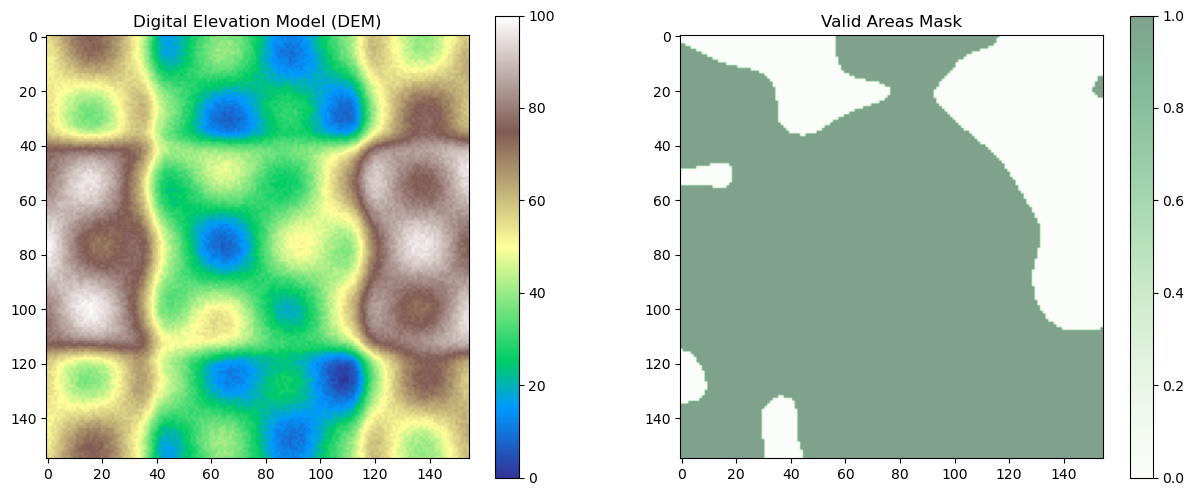

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Define map size
map_size = 155

# Generate structured DEM data
x, y = np.meshgrid(np.linspace(-10, 10, map_size), np.linspace(-10, 10, map_size))

# Create basin and range structure using combined functions and Gaussian filters
dem = (np.sin(x) * np.cos(y) * 20 + 
       np.sin(0.5 * x) * np.cos(0.5 * y) * 10 + 
       np.sin(0.25 * x) * np.cos(0.25 * y) * 5)

# Apply Gaussian filter to smooth out the DEM
dem = gaussian_filter(dem, sigma=2)

# Add aggressive cliffs and valleys
cliffs = (np.tanh(2 * (x - 5)) - np.tanh(2 * (x + 5))) * 20
valleys = - (np.tanh(2 * (y - 5)) - np.tanh(2 * (y + 5))) * 20
dem += cliffs + valleys

# Apply another Gaussian filter for smooth transitions
dem = gaussian_filter(dem, sigma=1)

# Add random noise
dem += np.random.rand(map_size, map_size) * 5

# Add lakes (negative values will be below sea level)
dem -= (np.exp(-0.05 * ((x - 2)**2 + (y - 2)**2)) * 30 + 
        np.exp(-0.05 * ((x + 2)**2 + (y + 2)**2)) * 30)

# Normalize DEM to be within 0 to 100 feet range
dem = 100 * (dem - np.min(dem)) / (np.max(dem) - np.min(dem))

# Generate structured valid areas mask using a Gaussian function
valid_mask_base = np.exp(-0.1 * (x**2 + y**2))  # Gaussian distribution

# Add blocks of random noise and apply Gaussian filter to create blobs
np.random.seed(42)  # For reproducibility
noise = np.random.rand(map_size, map_size)
smooth_noise = gaussian_filter(noise, sigma=10)  # Adjust sigma for larger/smaller blobs
valid_mask = (valid_mask_base + smooth_noise) > 0.5  # Combine and threshold

# Visualize the DEM and valid mask with terrain colormap and colorbars
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

c1 = axs[0].imshow(dem, cmap='terrain')
axs[0].set_title('Digital Elevation Model (DEM)')
fig.colorbar(c1, ax=axs[0], orientation='vertical')

c2 = axs[1].imshow(valid_mask, cmap='Greens', alpha=0.5)
axs[1].set_title('Valid Areas Mask')
fig.colorbar(c2, ax=axs[1], orientation='vertical')

plt.show()


In [20]:
def cast_ray(dem, obs_x, obs_y, angle, obs_height=60, max_radius=50):
    """
    Cast a ray from the observation point in a given direction and check for visibility.
    """
    dem_size = dem.shape[0]
    visible_points = []
    dx = np.cos(angle)
    dy = np.sin(angle)
    obs_elevation = dem[obs_x, obs_y] + obs_height
    
    for step in range(1, max_radius + 1):
        x = obs_x + step * dx
        y = obs_y + step * dy
        if x < 0 or y < 0 or x >= dem_size or y >= dem_size:
            break
        
        x_int = int(round(x))
        y_int = int(round(y))
        if x_int < 0 or y_int < 0 or x_int >= dem_size or y_int >= dem_size:
            break
        
        distance = np.sqrt((x - obs_x)**2 + (y - obs_y)**2)
        target_elevation = dem[x_int, y_int]
        line_elevation = obs_elevation - (obs_elevation - target_elevation) * (distance / max_radius)
        
        if target_elevation > line_elevation:
            break
        visible_points.append((x_int, y_int))
    
    return visible_points


def get_visible_area(dem, obs_x, obs_y, obs_height=60, max_radius=50, num_rays=90):
    dem_size = dem.shape[0]
    visible_area = np.zeros_like(dem)
    
    for angle in np.linspace(0, 2 * np.pi, num_rays, endpoint=False):
        visible_points = cast_ray(dem, obs_x, obs_y, angle, obs_height, max_radius)
        for x, y in visible_points:
            visible_area[x, y] = 1
    
    return visible_area


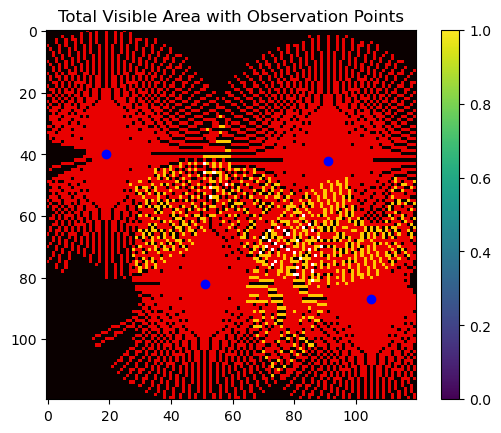

Observation Points: [(42, 91), (82, 51), (40, 19), (87, 105)]


In [21]:
from multiprocessing import Pool, cpu_count

def process_point(args):    #defined to take an args argument vs individual arguments for multiprocesssing
    dem, valid_mask, total_visible_area, obs_height, max_radius, num_rays, i, j = args
    if valid_mask[i, j] == 1 and total_visible_area[i, j] == 0:
        visible_area = get_visible_area(dem, i, j, obs_height, max_radius, num_rays)
        visibility_score = np.sum(visible_area * (1 - total_visible_area))
        return visibility_score, (i, j), visible_area
    return 0, None, None

def place_observation_points(dem, valid_mask, n_points, obs_height=10, max_radius=40, num_rays=90):
    dem_size = dem.shape[0]
    total_visible_area = np.zeros_like(dem)
    observation_points = []
    
    for _ in range(n_points):
        best_visibility = 0
        best_point = None
        best_visible_area = None
        
        with Pool(cpu_count()-1) as pool:
            results = pool.map(process_point, [(dem, valid_mask, total_visible_area, obs_height, max_radius, num_rays, i, j)
                                               for i in range(dem_size) for j in range(dem_size)])
        
        for visibility_score, point, visible_area in results:
            if visibility_score > best_visibility:
                best_visibility = visibility_score
                best_point = point
                best_visible_area = visible_area
        
        if best_point:
            observation_points.append(best_point)
            total_visible_area += best_visible_area
    
    return observation_points, total_visible_area

# Place observation points
n_points = 4
observation_points, total_visible_area = place_observation_points(dem, valid_mask, n_points)

# Visualize the total visible area
plt.imshow(total_visible_area, cmap='hot')
plt.title('Total Visible Area with Observation Points')
plt.scatter([p[1] for p in observation_points], [p[0] for p in observation_points], c='blue')
plt.colorbar(orientation='vertical')
plt.show()

print("Observation Points:", observation_points)


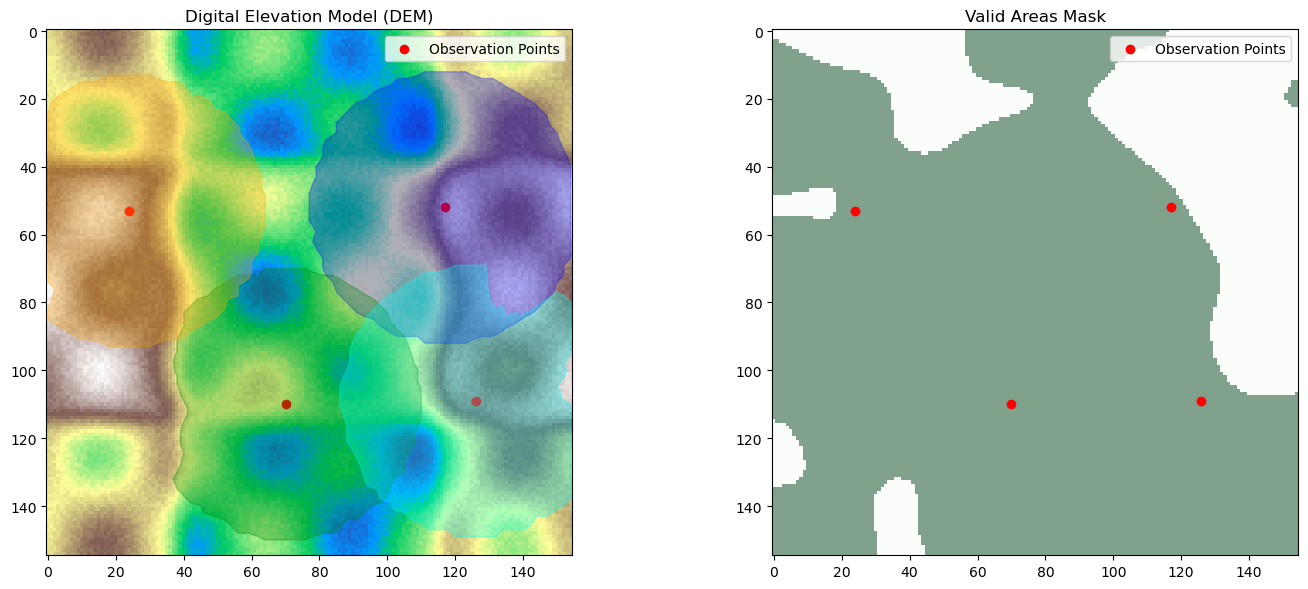

In [4]:
from shapely.geometry import Polygon as ShapelyPolygon

def plot_observation_points_with_polygons_on_dem(dem, valid_mask, observation_points, obs_height=10, max_radius=40, num_rays=90):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot DEM
    axes[0].imshow(dem, cmap='terrain')
    axes[0].set_title('Digital Elevation Model (DEM)')
    axes[0].scatter([p[1] for p in observation_points], [p[0] for p in observation_points], c='red', label='Observation Points')
    axes[0].legend()
    
    # Plot polygons for visible areas on DEM
    colors = ['blue', 'green', 'orange', 'cyan', 'magenta', 'plum', 'goldenrod']  # Unique colors for each observation point
    for idx, (obs_x, obs_y) in enumerate(observation_points):
        polygon_points = []
        for angle in np.linspace(0, 2 * np.pi, num_rays, endpoint=False):
            ray_x = [obs_x]
            ray_y = [obs_y]
            dx = np.cos(angle)
            dy = np.sin(angle)
            obs_elevation = dem[obs_x, obs_y] + obs_height

            for step in range(1, max_radius + 1):
                x = obs_x + step * dx
                y = obs_y + step * dy
                x_int = int(round(x))
                y_int = int(round(y))
                if x_int < 0 or y_int < 0 or x_int >= dem.shape[0] or y_int >= dem.shape[1]:
                    break

                distance = np.sqrt((x - obs_x)**2 + (y - obs_y)**2)
                target_elevation = dem[x_int, y_int]
                line_elevation = obs_elevation - (obs_elevation - target_elevation) * (distance / max_radius)

                if target_elevation > line_elevation:
                    break

                ray_x.append(x_int)
                ray_y.append(y_int)

            if len(ray_x) > 1:
                polygon_points.append((ray_x[-1], ray_y[-1]))  # Append the endpoint of the ray

        # Create a Shapely Polygon from the collected points
        polygon = ShapelyPolygon(polygon_points)
        
        # Plot the Polygon on DEM
        x, y = polygon.exterior.xy
        axes[0].fill(y, x, color=colors[idx], alpha=0.3)

    # Plot Valid Mask
    axes[1].imshow(valid_mask, cmap='Greens', alpha=0.5)
    axes[1].set_title('Valid Areas Mask')
    axes[1].scatter([p[1] for p in observation_points], [p[0] for p in observation_points], c='red', label='Observation Points')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_observation_points_with_polygons_on_dem(dem, valid_mask, observation_points)


In [1]:
### procede with a 3D variant of the problem

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.stats.qmc import PoissonDisk
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.ops import cascaded_union
#from multiprocessing import Pool, cpu_count

import numpy as np
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [50]:
# Define map size
map_size = 150

# Generate structured DEM data
x, y = np.meshgrid(np.linspace(-10, 10, map_size), np.linspace(-10, 10, map_size))

# Create basin and range structure using combined functions and Gaussian filters
dem = (np.sin(x) * np.cos(y) * 20 + 
       np.sin(0.5 * x) * np.cos(0.5 * y) * 10 + 
       np.sin(0.25 * x) * np.cos(0.25 * y) * 5)

# Apply Gaussian filter to smooth out the DEM
dem = gaussian_filter(dem, sigma=2)

# Add aggressive cliffs and valleys
cliffs = (np.tanh(2 * (x - 5)) - np.tanh(2 * (x + 5))) * 20
valleys = - (np.tanh(2 * (y - 5)) - np.tanh(2 * (y + 5))) * 20
dem += cliffs + valleys

# Apply another Gaussian filter for smooth transitions
dem = gaussian_filter(dem, sigma=1)

# Add random noise
dem += np.random.rand(map_size, map_size) * 5

# Add lakes (negative values will be below sea level)
dem -= (np.exp(-0.05 * ((x - 2)**2 + (y - 2)**2)) * 30 + 
        np.exp(-0.05 * ((x + 2)**2 + (y + 2)**2)) * 30)

# Normalize DEM to be within 0 to 100 feet range
dem = 100 * (dem - np.min(dem)) / (np.max(dem) - np.min(dem))

# Generate structured valid areas mask using a Gaussian function
valid_mask_base = np.exp(-0.1 * (x**2 + y**2))  # Gaussian distribution

# Add blocks of random noise and apply Gaussian filter to create blobs
np.random.seed(42)  # For reproducibility
noise = np.random.rand(map_size, map_size)
smooth_noise = gaussian_filter(noise, sigma=10)  # Adjust sigma for larger/smaller blobs
valid_mask = (valid_mask_base + smooth_noise) > 0.5  # Combine and threshold

# Create grid coordinates for pcolormesh
x, y = np.meshgrid(np.linspace(0, dem.shape[1], dem.shape[1]+1), np.linspace(0, dem.shape[0], dem.shape[0]+1))

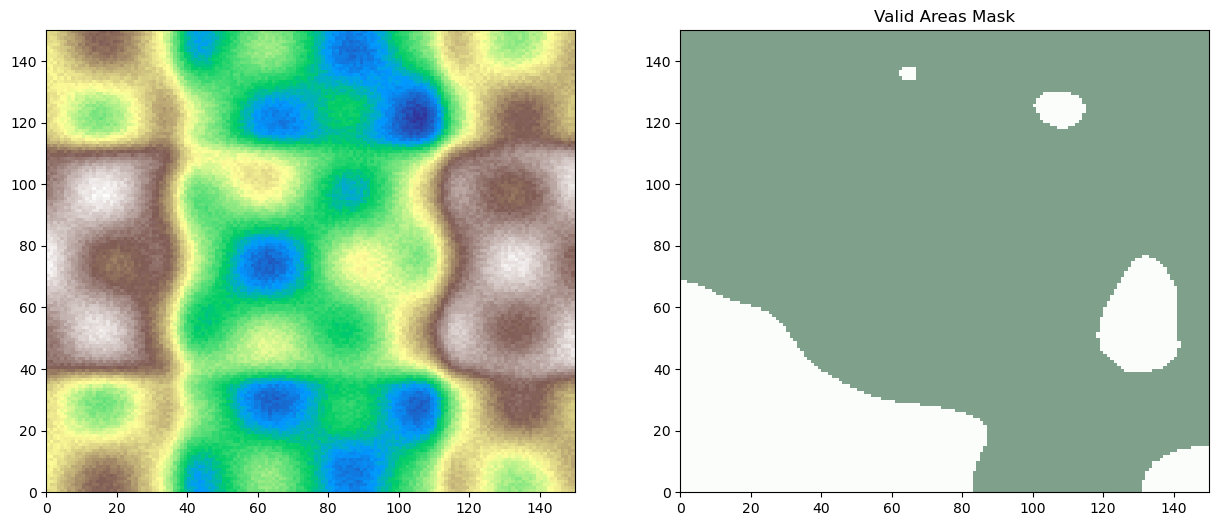

In [51]:
# Visualize the DEM and valid mask with terrain colormap and colorbars
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

c1 = axs[0].pcolormesh(x, y, dem, cmap='terrain', shading='auto')
plt.title('Digital Elevation Model (DEM)')
#plt.colorbar(label='Elevation')

c2 = axs[1].pcolormesh(x, y, valid_mask, cmap='Greens', shading='auto', alpha=0.5)
axs[1].set_title('Valid Areas Mask')

plt.show()


In [52]:
def get_visible_area_3d(dem, obs_x, obs_y, obs_height, max_radius, num_rays):
    dem_size = dem.shape[0]
    visible_area = np.zeros_like(dem)
    
    for angle in np.linspace(0, 2 * np.pi, num_rays, endpoint=False):
        dx = np.cos(angle)
        dy = np.sin(angle)
        
        obs_elevation = dem[obs_x, obs_y] + obs_height
        
        for step in range(1, max_radius + 1):
            x = obs_x + step * dx
            y = obs_y + step * dy
            x_int = int(round(x))
            y_int = int(round(y))
            
            if x_int < 0 or y_int < 0 or x_int >= dem_size or y_int >= dem_size:
                break
            
            target_elevation = dem[x_int, y_int]
            line_elevation = obs_elevation - ((obs_elevation - target_elevation) * (step / max_radius))
            
            if target_elevation > line_elevation:
                visible_area[x_int, y_int] = 1
            else:
                break
    
    return visible_area

In [53]:
"""
2D case - return an approximaiton of the visible area based on the length of n rays broadcast from an observation point
"""
def get_visible_area(dem, obs_x, obs_y, obs_height=60, max_radius=50, num_rays=90):
    dem_size = dem.shape[0]
    visible_area = np.zeros_like(dem)
    
    for angle in np.linspace(0, 2 * np.pi, num_rays, endpoint=False):
        visible_points = cast_ray(dem, obs_x, obs_y, angle, obs_height, max_radius)
        for x, y in visible_points:
            visible_area[x, y] = 1
    
    return visible_area

"""
2D placement of points using kmeans and a mask of valid locations 
"""
def kmeans_sampling_points(dem, valid_mask, n_points):

    valid_indices = np.column_stack(np.where(valid_mask))
    kmeans = KMeans(n_clusters=n_points, random_state=0).fit(valid_indices)
    return np.round(kmeans.cluster_centers_).astype(int)


"""
2D placement of points using Poisson_disk and a mask of valid locations - alternative to kmeans
    - Not fully implemented, radius function needs to come from the calling function (presently using a default of 20)
"""
def poisson_disk_sampling_points(dem, valid_mask, n_points, radius=0.60, ncandidates=30):
    """
    Use Poisson disk sampling to place observation points using scipy.stats.qmc.PoissonDisk.
    
    Parameters:
    - dem: 2D array representing the DEM (digital elevation model).
    - valid_mask: 2D boolean array indicating valid observation locations.
    - n_points: Number of observation points to place.
    - radius: Minimum distance between points, relative to the domain size.
    - ncandidates: Number of candidate points to sample for each new point.
    
    Returns:
    - points: Array of shape (n_points, 2) with the coordinates of the sampled points.
    """
    height, width = valid_mask.shape

    # Initialize the Poisson disk sampler
    sampler = PoissonDisk(d=2, radius=radius, ncandidates=ncandidates, optimization='lloyd', seed=None)
    
    points = []
    while len(points) < n_points:
        # Generate more points than needed to ensure enough valid points are obtained
        sampled_points = sampler.random(n_points * 2)
        sampled_points[:, 0] *= width
        sampled_points[:, 1] *= height
        sampled_points = sampled_points.astype(int)
        
        # Filter points to ensure they fall within valid areas of the DEM
        for point in sampled_points:
            if valid_mask[point[1], point[0]]:  # Note the switch to (y, x) due to numpy row-major order
                points.append(point)
                if len(points) >= n_points:
                    break

    return np.array(points[:n_points])

"""
2D visibility score of a point given an x-y location to place the point on the dem, additional obs height, the dem itself, and ray parameters
"""
def process_point(args):
    dem, valid_mask, total_visible_area, obs_height, max_radius, num_transects, i, j = args
    if valid_mask[i, j] == 1 and total_visible_area[i, j] == 0:
        visible_area = get_visible_area(dem, i, j, obs_height, max_radius, num_transects)
        visibility_score = np.sum(visible_area * (1 - total_visible_area))
        return visibility_score, (i, j), visible_area
    return 0, None, None

"""
2D visibility driver function, aggrate visibiity score from all points - 
    - this is slow and a bit of a mess - threw multiprocessing at it - something is deeply broken and it needs a re-write for efficency
"""
def visibility_optimized_points(dem, valid_mask, n_points, obs_height=10, max_radius=40, num_transects=90):
    dem_size = dem.shape[0]
    total_visible_area = np.zeros_like(dem)
    observation_points = []
    
    for _ in range(n_points):
        best_visibility = 0
        best_point = None
        best_visible_area = None
        
        with Pool(cpu_count()-1) as pool:
            results = pool.map(process_point, [(dem, valid_mask, total_visible_area, obs_height, max_radius, num_transects, i, j)
                                               for i in range(dem_size) for j in range(dem_size)])
        
        for visibility_score, point, visible_area in results:
            if visibility_score > best_visibility:
                best_visibility = visibility_score
                best_point = point
                best_visible_area = visible_area
        
        if best_point:
            observation_points.append(best_point)
            total_visible_area += best_visible_area
    
    return observation_points, total_visible_area

"""
Optimization objective, called by visibility_optimized_points_3d
    - Prioriries
    - 1) Do not place on invalid areas (handled by location aware Kmeans initial guesses passed to this function followd by eplicit checks)
    - 2) Map coverage - we desire high coverage for the given n points - this woll double-count areas with overlap as is
    - 3) Obs point proximity - we discourage clustering in favor of disperse solutions - this is a pesudo work-around to map coverage 
"""
def objective(x, dem, obs_height, max_radius, num_rays, n_points, dem_size, valid_mask):
    total_visibility = 0
    observation_points = []
    total_visible_area = np.zeros_like(dem)
    penalty = 0

    if np.any(np.isnan(x)):
        return np.inf
    
    for i in range(n_points):
        obs_x = int(round(x[i * 2]))
        obs_y = int(round(x[i * 2 + 1]))
        
        if not valid_mask[obs_y, obs_x]:
            return np.inf
        
        visible_area = get_visible_area_3d(dem, obs_x, obs_y, obs_height, max_radius, num_rays)
        total_visibility += np.sum(visible_area * (1 - total_visible_area))
        observation_points.append((obs_x, obs_y))
        total_visible_area += visible_area

    map_coverage = np.sum(total_visible_area > 0) / dem_size**2
    if map_coverage < 1.0:
        penalty += (1.0 - map_coverage)**2 * 10000

    if len(observation_points) > 1:
        distances = pdist(observation_points)
        min_distance = np.min(distances)
        mean_distance = np.mean(distances)
        distance_penalty = (1 / (min_distance + 1e-6)) + (1 / (mean_distance + 1e-6))
        penalty += distance_penalty * 100

    total_penalty = total_visibility - penalty
    return -total_penalty


"""
Optimization driver function using scipy.optimize.minimum if method=visibility_3d is called from place_observation_points_3d()
"""
def visibility_optimized_points_3d(dem, valid_mask, n_points, obs_height, max_radius, num_rays):
    dem_size = dem.shape[0]
    valid_points = np.column_stack(np.where(valid_mask))

    bounds = [(0, dem_size - 1)] * (n_points * 2)
    
    result = differential_evolution(objective, bounds,
                                    args=(dem, obs_height, max_radius, num_rays, n_points, dem_size, valid_mask),
                                    strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, workers=4)

    optimized_points = result.x.reshape(-1, 2)
    observation_points = [(int(round(point[0])), int(round(point[1]))) for point in optimized_points]
    
    # Ensure that the number of points is exactly n_points and they are valid
    observation_points = [pt for pt in observation_points if valid_mask[pt[1], pt[0]]]
    while len(observation_points) < n_points:
        additional_point = valid_points[np.random.choice(len(valid_points))]
        observation_points.append((int(additional_point[0]), int(additional_point[1])))
    observation_points = observation_points[:n_points]
    
    return observation_points, total_visible_area

"""
Parent function to generate n points with a DEM, valid mask, method, and additional parameters describing how the observation works
"""
def place_observation_points_3d(dem, valid_mask, n_points, method='kmeans', obs_height=10, max_radius=40, num_transects=90):
    if method == 'kmeans':
        observation_points = kmeans_sampling_points(dem, valid_mask, n_points)
    elif method == 'poisson_disk':
        observation_points = poisson_disk_sampling_points(dem, valid_mask, n_points)
    elif method == 'visibility_2d':
        observation_points, total_visible_area = visibility_optimized_points(dem, valid_mask, n_points, obs_height, max_radius, num_transects)
    elif method == 'visibility_3d':
        observation_points, total_visible_area = visibility_optimized_points_3d(dem, valid_mask, n_points, obs_height, max_radius, num_transects)
    else:
        raise ValueError(f"Unknown method: {method}")

    # redundent for those methods returning a visible area already
    all_polygons = []
    total_visible_area = np.zeros_like(dem)

    # will double count overlap area, but we are not penalizing overlap solutions, just poor map coverage
    for obs_x, obs_y in observation_points:
        visible_area = get_visible_area_3d(dem, obs_x, obs_y, obs_height, max_radius, num_transects)
        all_polygons.append(visible_area)
        total_visible_area += visible_area
    
    return observation_points, total_visible_area, all_polygons


In [54]:
def plot_observation_points_with_polygons_3d(dem, valid_mask, observation_points, all_polygons, obs_height=15, max_radius=75, num_transects=90):
    plt.figure(figsize=(10, 8))
    
    # Create grid coordinates for pcolormesh
    x, y = np.meshgrid(np.linspace(0, dem.shape[1], dem.shape[1]+1), np.linspace(0, dem.shape[0], dem.shape[0]+1))
    
    # Plot DEM as pcolormesh
    plt.pcolormesh(x, y, dem, cmap='terrain', shading='auto')
    plt.title('Digital Elevation Model (DEM)')
    plt.colorbar(label='Elevation')
    plt.scatter([p[1] for p in observation_points], [p[0] for p in observation_points], c='red', label='Observation Points')
    plt.legend()

    # Create grid coordinates for valid_mask
    valid_x, valid_y = np.meshgrid(np.arange(valid_mask.shape[1] + 1), np.arange(valid_mask.shape[0] + 1))
    
    # Overlay filled contour with hatching for valid and invalid areas based on the valid mask
    plt.contourf(valid_x[:-1, :-1], valid_y[:-1, :-1], valid_mask, colors='gray', levels=[0, 0.5], hatches=['', '\\'], alpha=0.5)

    # Plot polygons for visible areas
    colors = ['blue', 'green', 'orange', 'cyan', 'magenta', 'plum', 'goldenrod', 'palegreen']  # Unique colors for each observation point
    for idx, (obs_x, obs_y) in enumerate(observation_points):
        polygon_points = []
        for angle in np.linspace(0, 2 * np.pi, num_transects, endpoint=False):
            dx = np.cos(angle)
            dy = np.sin(angle)
            obs_elevation = dem[int(np.round(obs_x)), int(np.round(obs_y))]  # Convert to integers

            max_distance = 0
            max_x, max_y = obs_x, obs_y

            for step in range(1, max_radius + 1):
                x = obs_x + step * dx
                y = obs_y + step * dy
                x_int = int(round(x))
                y_int = int(round(y))
                if x_int < 0 or y_int < 0 or x_int >= dem.shape[0] or y_int >= dem.shape[1]:
                    break

                distance = np.sqrt((x - obs_x)**2 + (y - obs_y)**2)
                target_elevation = dem[x_int, y_int]
                line_elevation = (obs_elevation + obs_height) - ((obs_elevation + obs_height) - target_elevation) * (distance / max_radius)

                if target_elevation > line_elevation:
                    break

                if distance > max_distance:
                    max_distance = distance
                    max_x, max_y = x_int, y_int

            polygon_points.append((max_x, max_y))  # Append the point to the polygon

        # Create a Shapely Polygon from the collected points
        polygon = ShapelyPolygon(polygon_points)
        
        # Plot the Polygon
        x, y = polygon.exterior.xy
        plt.fill(y, x, color=colors[idx], linewidth=2, alpha=0.3)

    plt.tight_layout()
    plt.show()

[(82, 75), (142, 120), (96, 8), (77, 143), (16, 104)]


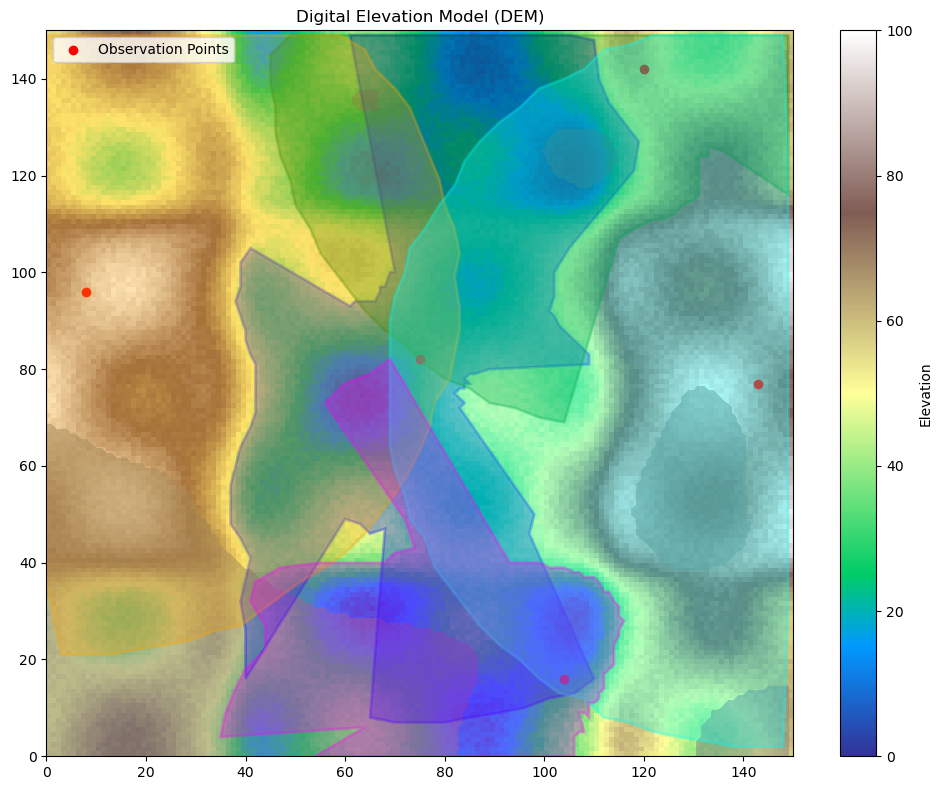

In [57]:
n_points = 5
obs_height = 20
obs_max_radius = 75
n_transects = 90
method = 'visibility_3d'  #"kmeans", "poisson_disk" "visibility"

observation_points, total_visible_area, all_polygons = place_observation_points_3d(dem=dem,
                                                                                   valid_mask=valid_mask,
                                                                                   n_points = n_points,
                                                                                   method=method,
                                                                                   obs_height=obs_height,
                                                                                   max_radius=obs_max_radius,
                                                                                   num_transects= n_transects)
print(observation_points)
plot_observation_points_with_polygons_3d(dem,
                                         valid_mask,
                                         observation_points,
                                         all_polygons,
                                         obs_height=obs_height,
                                         max_radius=obs_max_radius,
                                         num_transects=n_transects)


In [58]:
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, HTML

In [61]:
# Function to create the 3D plot using Plotly
# Function to create the 3D plot using Plotly
def plot_dem(dem, valid_mask, observation_points, all_polygons, obs_height, elev=30, azim=45):
    x = np.arange(dem.shape[1])
    y = np.arange(dem.shape[0])
    x, y = np.meshgrid(x, y)
    z = dem

    # Create surface plot for DEM
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, colorscale='tropic', opacity=0.8)])

    # Overlay valid areas
    fig.add_trace(go.Surface(z=z, x=x, y=y, surfacecolor=valid_mask, opacity=0.3))

    # Plot observation points
    obs_x = [p[1] for p in observation_points]
    obs_y = [p[0] for p in observation_points]
    obs_z = [dem[int(p[0]), int(p[1])] + obs_height for p in observation_points]
    fig.add_trace(go.Scatter3d(x=obs_x, y=obs_y, z=obs_z, mode='markers', marker=dict(size=5, color='red'), name='Observation Points'))

    # Add lines from observation points to terrain surface
    for p in observation_points:
        obs_x, obs_y = p[1], p[0]
        obs_z_surface = dem[int(p[0]), int(p[1])]
        obs_z_point = obs_z_surface + obs_height
        fig.add_trace(go.Scatter3d(x=[obs_x, obs_x], y=[obs_y, obs_y], z=[obs_z_point, obs_z_surface], mode='lines', line=dict(color='red', width=2), showlegend=False))

    # Add polygons at the respective height of each observation point
    for idx, (obs_x, obs_y) in enumerate(observation_points):
        polygon_points = all_polygons[idx]
        polygon_points = np.array(polygon_points)
        polygon_points = np.column_stack((polygon_points[:, 1], polygon_points[:, 0], np.full_like(polygon_points[:, 0], obs_z[idx])))
        fig.add_trace(go.Mesh3d(x=polygon_points[:, 0], y=polygon_points[:, 1], z=polygon_points[:, 2], opacity=0.5, color='blue', name=f'Polygon {idx+1}'))

    # Set layout
    fig.update_layout(
        title='3D View of DEM, Valid Areas, & Observation Points',
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Elevation',
                   aspectmode='manual', aspectratio=dict(x=1, y=1, z=0.5),
                   camera=dict(eye=dict(x=np.sin(np.deg2rad(azim))*np.cos(np.deg2rad(elev)),
                                        y=np.sin(np.deg2rad(azim))*np.sin(np.deg2rad(elev)),
                                        z=np.cos(np.deg2rad(elev)))),
                   xaxis=dict(range=[0, dem.shape[1]]),
                   yaxis=dict(range=[0, dem.shape[0]]),
                   zaxis=dict(range=[dem.min(), max(dem.max(), max(obs_z))])),
        width=1000,
        height=800
    )

    # Adjust colorbar position and size
    fig.update_layout(coloraxis_colorbar=dict(yanchor='top', y=0.9, len=0.4))

    # Show plot
    fig.show()

# Create interactive widgets
elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elevation')
azim_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=45, description='Azimuth')

# Inject CSS for cell height
display(HTML("""
<style>
.jp-OutputArea {
    max-height: 800px;
    overflow-y: auto;
}
</style>
"""))

# Display interactive plot
interact(plot_dem, dem=widgets.fixed(dem), valid_mask=widgets.fixed(valid_mask),
         observation_points=widgets.fixed(observation_points), all_polygons=widgets.fixed(all_polygons),
         obs_height=widgets.fixed(obs_height), elev=elev_slider, azim=azim_slider)



interactive(children=(FloatSlider(value=30.0, description='Elevation', max=90.0, step=1.0), FloatSlider(value=…

<function __main__.plot_dem(dem, valid_mask, observation_points, all_polygons, obs_height, elev=30, azim=45)>